In [114]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_accf_grid

In [52]:
# Preprocessing

df = pd.read_csv('bike_sharing_training.csv')
df.rename(columns={'cnt': 'y', 'dteday': 'ds'}, inplace=True)

df['ds'] = pd.to_datetime(df['ds'], format='%m/%d/%Y')
df[['weathersit_2', 'weathersit_3']] = pd.get_dummies(df['weathersit'], drop_first=True)
df.drop(columns=['instant', 'season', 'yr', 'mnth', 'weekday', 'casual', 'registered', 'weathersit'], 
        inplace=True)  # Remove unneeded variables

df.set_index('ds', inplace=True)
df.index.freq = 'D'

## Exploratory Data Analysis

<Axes: xlabel='ds'>

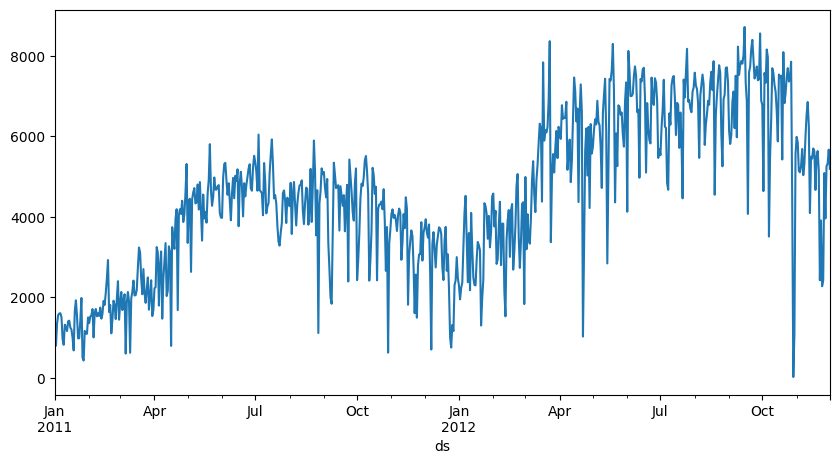

In [54]:
plt.figure(figsize=(10, 5))
df['y'].plot()


In [81]:
# Which factors are correlated with the daily count of shared bikes?

df.corr()[['y']].sort_values('y', ascending=False)

,y
y,1.000000
atemp,0.633885
temp,0.631649
workingday,0.048162
holiday,-0.058080
hum,-0.101409
weathersit_2,-0.166746
windspeed,-0.234871
weathersit_3,-0.234874


In [87]:
#What is the significance level of the variable associations with y?

{'atemp': pearsonr(df['y'], df['atemp'])[1], \
'temp': pearsonr(df['y'], df['temp'])[1], \
'windspeed': pearsonr(df['y'], df['windspeed'])[1], \
'hum': pearsonr(df['y'], df['hum'])[1]}

{'atemp': 4.808082149653423e-80,
 'temp': 2.5097397796383583e-79,
 'windspeed': 3.05974963187083e-10,
 'hum': 0.007207881612862129}

In [88]:
# What is the mean count for each weathersit?
df.pivot_table(columns=['weathersit_2', 'weathersit_3'], values='y', aggfunc='mean').transpose().reset_index()

,weathersit_2,weathersit_3,y
0,False,False,4881.733925
1,False,True,1871.400000
2,True,False,4065.508696


In [ ]:
# What is the significance level of the difference of the means? (For weathersits 2 and 3) 
f_oneway(df[df['weathersit_2'] == True]['y'], 
         df[df['weathersit_3'] == True]['y'])[1]

2.9835810336291315e-07

In [138]:
# What is the mean count for each workingday status?
df.pivot_table(columns=['workingday'], values='y', aggfunc='mean').transpose()

,y
workingday,
0,4390.457014
1,4591.387500


In [140]:
# What is the significance level of the difference of the means?
f_oneway(df[df['workingday'] == 1]['y'], 
         df[df['workingday'] == 0]['y'])[1]

0.20279756941426727

In [141]:
# What is the mean count for each workingday status?
df.pivot_table(columns=['holiday'], values='y', aggfunc='mean').transpose()

,y
holiday,
0,4547.334802
1,3871.100000


In [142]:
# What is the significance level of the difference of the means?
f_oneway(df[df['holiday'] == 1]['y'], 
         df[df['holiday'] == 0]['y'])[1]

0.12446261388088206

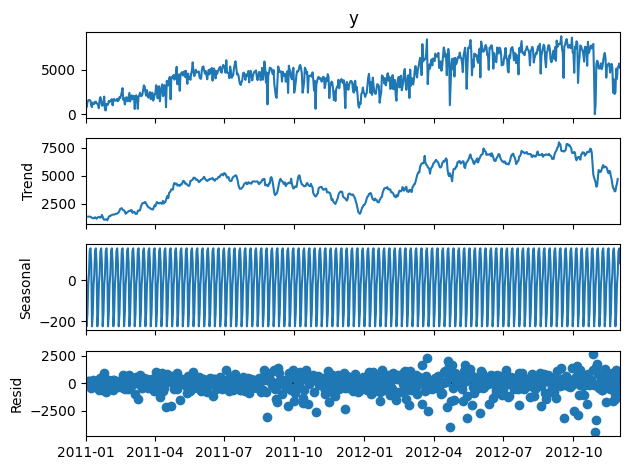

In [113]:
y_decompose = seasonal_decompose(df['y'], model='additive',
                   period=7)

y_decompose.plot()
plt.show()

<Axes: xlabel='ds'>

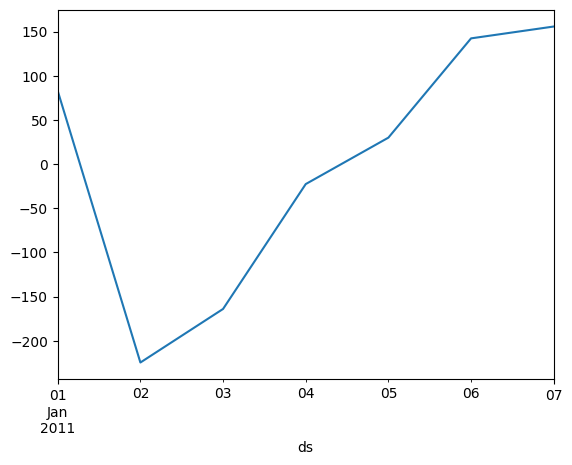

In [110]:
y_decompose.seasonal[:7].plot()

In [128]:
df.index.shape

(701,)

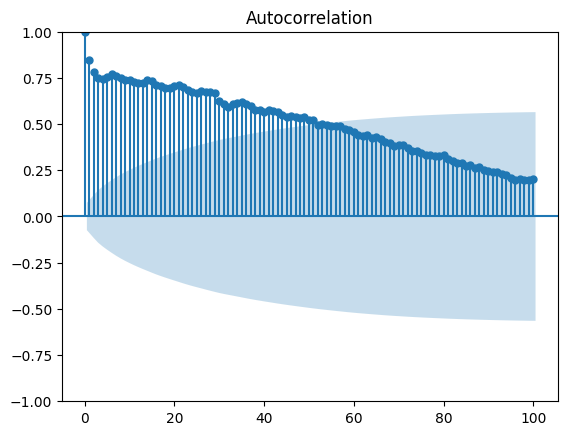

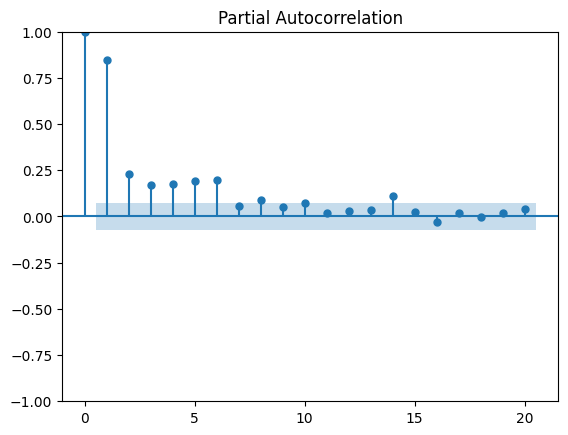

In [133]:
plot_acf(df['y'], lags=100)
plot_pacf(df['y'], lags=20)
plt.show()

In [176]:
def add_holiday(holiday, holiday_date):

    if holiday_date.__class__ == str:
        ds = pd.to_datetime(['2011-'+holiday_date, '2012-'+holiday_date])
    
    elif holiday_date.__class__ == list:
        ds = pd.to_datetime(holiday_date)
    
    elif holiday_date.__class__ == pd.core.indexes.datetimes.DatetimeIndex:
        ds = holiday_date

    holiday_df = pd.DataFrame({'holiday': holiday,
                              'ds': ds,
                              'lower_window': -3,
                              'upper_window': 3})
    
    return holiday_df

In [187]:
gen_holidays = add_holiday('gen_holi', df[df['holiday']==1].index)
xmas = add_holiday('christmas', '12-24')
nye = add_holiday('new_year', '12-31')
easter = add_holiday('easter', ['2011-04-24', '2012-04-08'])

#Combine holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter]).set_index('ds')

holidays.sort_index()#.asfreq('D')

,holiday,lower_window,upper_window
ds,,,
2011-01-17,gen_holi,-3,3
2011-02-21,gen_holi,-3,3
2011-04-15,gen_holi,-3,3
2011-04-24,easter,-3,3
2011-05-30,gen_holi,-3,3
2011-07-04,gen_holi,-3,3
2011-09-05,gen_holi,-3,3
2011-10-10,gen_holi,-3,3
2011-11-11,gen_holi,-3,3
